In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression  # Example classifier for RFE
from sklearn.ensemble import RandomForestClassifier  # Example classifier for SelectFromModel
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

#Basic Operation

In [7]:
df=pd.read_csv('/content/DDos.pcap_ISCX.csv')

In [8]:
df.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                       6   
4                             0                       6   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0                       6                      6.0                     0.0   
1                       6                      6.0                     0.0   
2                       6                      6.0                     0.0   
3                       6                      6.0                     0.0   
4                       6                      6.0                     0.0   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...                     20          0.0          0.0            0   
1  ...                     20          0.0          0.0            0   
2  ...                     20          0.0          0.0            0   
3  ...                     20          0.0          0.0            0   
4  ...                     20          0.0          0.0            0   

    Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0            0        0.0        0.0          0          0  BENIGN  
1            0        0.0        0.0          0          0  BENIGN  
2            0        0.0        0.0          0          0  BENIGN  
3            0        0.0        0.0          0          0  BENIGN  
4            0        0.0        0.0          0          0  BENIGN  

[5 rows x 79 columns]

In [9]:
df.shape

(225745, 79)

In [10]:
null_columns = df.isnull().sum()
null_columns = null_columns[null_columns > 0]  # Filter columns with null values
print(null_columns)


Flow Bytes/s    4
dtype: int64


In [ ]:
df.dropna(subset=[' Label'], inplace=True)  # Drop rows with NaNs in the target variable first
X = df.drop([' Label'], axis=1)
y = df[' Label']

In [ ]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

In [ ]:
from sklearn.impute import SimpleImputer


#Feature selection

In [ ]:
correlations = X.corrwith(pd.Series(y))

# Select features with high correlation coefficients
high_corr_features = correlations[abs(correlations) > 0.3].index  # Adjust correlation threshold as needed

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
upper_bound = X_train.quantile(0.99)  # 99th percentile
lower_bound = X_train.quantile(0.01)  # 1st percentile
X_train = X_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
imputer = SimpleImputer(strategy='median')  # You can choose other strategies like 'median' or 'most_frequent'

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
#X_test_imputed = imputer.transform(X_test)
# Define the number of features to select for SelectKBest and RFE
k_best_features = 10  # Adjust as needed
rfe_num_features = 15  # Adjust as needed

# Step 1: Apply different feature selection methods
# Method 1: SelectKBest with mutual information
skb_mi = SelectKBest(score_func=mutual_info_classif, k=k_best_features)
X_skb_mi = skb_mi.fit_transform(X_train_imputed, y_train)
selected_features_skb_mi = X.columns[skb_mi.get_support(indices=True)]

# Method 2: SelectKBest with ANOVA F-value
skb_f = SelectKBest(score_func=f_classif, k=k_best_features)
X_skb_f = skb_f.fit_transform(X_train_imputed, y_train)
selected_features_skb_f = X.columns[skb_f.get_support(indices=True)]

# Method 3: Recursive Feature Elimination (RFE) with Logistic Regression
rfe_lr = RFE(LogisticRegression(), n_features_to_select=rfe_num_features)
X_rfe_lr = rfe_lr.fit_transform(X_train_imputed, y_train)
selected_features_rfe_lr = X.columns[rfe_lr.get_support(indices=True)]

# Method 4: Lasso-based feature selection
lasso_model = RandomForestClassifier()  # Example classifier for SelectFromModel
lasso_selector = SelectFromModel(lasso_model)
X_lasso = lasso_selector.fit_transform(X_train_imputed, y_train)
selected_features_lasso = X.columns[lasso_selector.get_support(indices=True)]

# Step 2: Intersect the selected features from different methods
selected_features_intersection = set(selected_features_skb_mi) & set(selected_features_skb_f) & \
                                set(selected_features_rfe_lr) & set(selected_features_lasso)

# Add high correlated features to the selected features
final_selected_features = list(selected_features_intersection.union(high_corr_features))

print("Final Selected Features:", final_selected_features)

Final Selected Features: [' URG Flag Count', ' Min Packet Length', ' min_seg_size_forward', ' Bwd Packet Length Min', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Packet Length Std', 'Total Length of Fwd Packets', ' Avg Fwd Segment Size', ' Down/Up Ratio', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Average Packet Size', ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length', ' Bwd Packet Length Std', 'Bwd IAT Total', ' Subflow Fwd Bytes', ' Avg Bwd Segment Size', ' Fwd Packet Length Mean', ' Destination Port']


In [ ]:
len(final_selected_features)

22

In [ ]:
data=df[[' URG Flag Count', ' Min Packet Length', ' min_seg_size_forward', ' Bwd Packet Length Min', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Packet Length Std', 'Total Length of Fwd Packets', ' Avg Fwd Segment Size', ' Down/Up Ratio', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Average Packet Size', ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length', ' Bwd Packet Length Std', 'Bwd IAT Total', ' Subflow Fwd Bytes', ' Avg Bwd Segment Size', ' Fwd Packet Length Mean', ' Destination Port']]

In [ ]:
y_series = pd.Series(y, name='Label')  # Give the series a name
f_d=pd.concat([data, y_series], axis=1)
f_d.head()
# Concatenate data and y_series along columns (axis=1)
data_f = pd.concat([data, df[' Label']], axis=1)
data_f.head()

URG Flag Count   Min Packet Length   min_seg_size_forward  \
0                0                   6                     20   
1                1                   6                     20   
2                1                   6                     20   
3                1                   6                     20   
4                0                   6                     20   

    Bwd Packet Length Min   Fwd Packet Length Max   Fwd Packet Length Std  \
0                       0                       6                     0.0   
1                       6                       6                     0.0   
2                       6                       6                     0.0   
3                       6                       6                     0.0   
4                       0                       6                     0.0   

    Packet Length Std  Total Length of Fwd Packets   Avg Fwd Segment Size  \
0                 0.0                           12                    6.0   
1                 0.0                            6                    6.0   
2                 0.0                            6                    6.0   
3                 0.0                            6                    6.0   
4                 0.0                           12                    6.0   

    Down/Up Ratio  ...   Packet Length Variance   Packet Length Mean  \
0               0  ...                      0.0                  6.0   
1               1  ...                      0.0                  6.0   
2               1  ...                      0.0                  6.0   
3               1  ...                      0.0                  6.0   
4               0  ...                      0.0                  6.0   

    Max Packet Length   Bwd Packet Length Std  Bwd IAT Total  \
0                   6                     0.0              0   
1                   6                     0.0              0   
2                   6                     0.0              0   
3                   6                     0.0              0   
4                   6                     0.0              0   

    Subflow Fwd Bytes   Avg Bwd Segment Size   Fwd Packet Length Mean  \
0                  12                    0.0                      6.0   
1                   6                    6.0                      6.0   
2                   6                    6.0                      6.0   
3                   6                    6.0                      6.0   
4                  12                    0.0                      6.0   

    Destination Port   Label  
0              54865  BENIGN  
1              55054  BENIGN  
2              55055  BENIGN  
3              46236  BENIGN  
4              54863  BENIGN  

[5 rows x 23 columns]

In [ ]:
f_d.head()

URG Flag Count   Min Packet Length   min_seg_size_forward  \
0                0                   6                     20   
1                1                   6                     20   
2                1                   6                     20   
3                1                   6                     20   
4                0                   6                     20   

    Bwd Packet Length Min   Fwd Packet Length Max   Fwd Packet Length Std  \
0                       0                       6                     0.0   
1                       6                       6                     0.0   
2                       6                       6                     0.0   
3                       6                       6                     0.0   
4                       0                       6                     0.0   

    Packet Length Std  Total Length of Fwd Packets   Avg Fwd Segment Size  \
0                 0.0                           12                    6.0   
1                 0.0                            6                    6.0   
2                 0.0                            6                    6.0   
3                 0.0                            6                    6.0   
4                 0.0                           12                    6.0   

    Down/Up Ratio  ...   Packet Length Variance   Packet Length Mean  \
0               0  ...                      0.0                  6.0   
1               1  ...                      0.0                  6.0   
2               1  ...                      0.0                  6.0   
3               1  ...                      0.0                  6.0   
4               0  ...                      0.0                  6.0   

    Max Packet Length   Bwd Packet Length Std  Bwd IAT Total  \
0                   6                     0.0              0   
1                   6                     0.0              0   
2                   6                     0.0              0   
3                   6                     0.0              0   
4                   6                     0.0              0   

    Subflow Fwd Bytes   Avg Bwd Segment Size   Fwd Packet Length Mean  \
0                  12                    0.0                      6.0   
1                   6                    6.0                      6.0   
2                   6                    6.0                      6.0   
3                   6                    6.0                      6.0   
4                  12                    0.0                      6.0   

    Destination Port  Label  
0              54865      0  
1              55054      0  
2              55055      0  
3              46236      0  
4              54863      0  

[5 rows x 23 columns]

High Correlation Features: Index([' Packet Length Std', ' Bwd Packet Length Mean',
       'Bwd Packet Length Max', ' Average Packet Size',
       ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length',
       ' Bwd Packet Length Std', ' Avg Bwd Segment Size'],
      dtype='object')


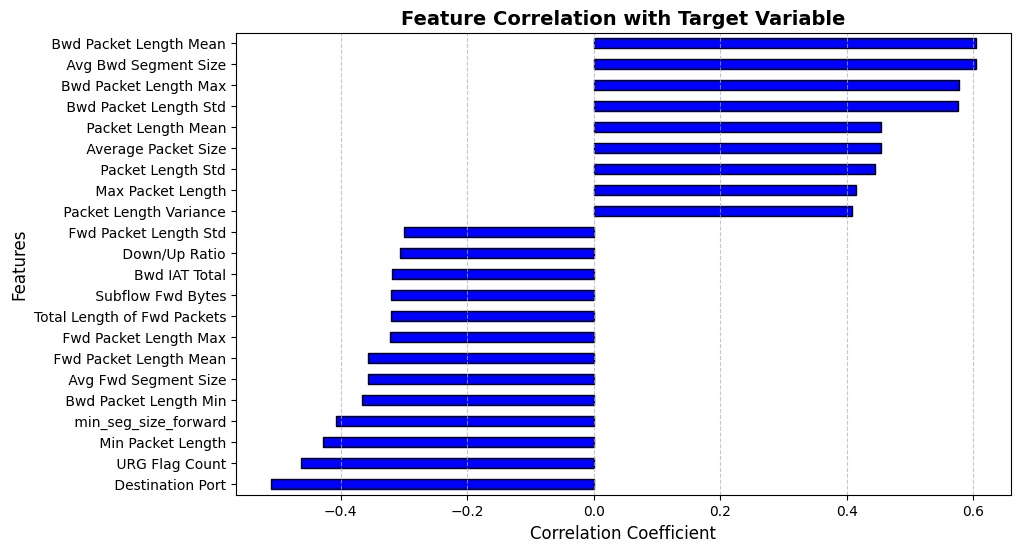

In [ ]:
X = f_d.drop(['Label'], axis=1)
y = f_d['Label']
corr_values = X.corrwith(y)
high_pos_corr_features = corr_values[corr_values > 0.3].index
print("High Correlation Features:", high_pos_corr_features)

plt.figure(figsize=(10, 6))
corr_values.sort_values().plot(kind='barh', color='blue', edgecolor='black')


plt.title("Feature Correlation with Target Variable", fontsize=14, fontweight='bold')
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)


plt.show()

**last and final selected feature**:

' Packet Length Std',

' Bwd Packet Length Mean',

'Bwd Packet Length Max',

' Average Packet Size',

' Packet Length Variance',

' Packet Length Mean',

' Max Packet Length',

' Bwd Packet Length Std',

' Avg Bwd Segment Size'

In [11]:
final_df=df[[' Packet Length Std', ' Bwd Packet Length Mean',
       'Bwd Packet Length Max', ' Average Packet Size',
       ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length',
       ' Bwd Packet Length Std', ' Avg Bwd Segment Size', ' Label']]

In [13]:
final_df.to_csv('DDos_final.csv', index=False)

#Exploratory Data Analysis (EDA)

In [128]:
ddos_data=pd.read_csv("/content/DDos_final.csv")
ddos_data.head()

Packet Length Std   Bwd Packet Length Mean  Bwd Packet Length Max  \
0                 0.0                      0.0                      0   
1                 0.0                      6.0                      6   
2                 0.0                      6.0                      6   
3                 0.0                      6.0                      6   
4                 0.0                      0.0                      0   

    Average Packet Size   Packet Length Variance   Packet Length Mean  \
0                   9.0                      0.0                  6.0   
1                   9.0                      0.0                  6.0   
2                   9.0                      0.0                  6.0   
3                   9.0                      0.0                  6.0   
4                   9.0                      0.0                  6.0   

    Max Packet Length   Bwd Packet Length Std   Avg Bwd Segment Size   Label  
0                   6                     0.0                    0.0  BENIGN  
1                   6                     0.0                    6.0  BENIGN  
2                   6                     0.0                    6.0  BENIGN  
3                   6                     0.0                    6.0  BENIGN  
4                   6                     0.0                    0.0  BENIGN

In [94]:
ddos_data.shape

(225745, 10)

In [95]:
ddos_data.isnull().sum()

Packet Length Std         0
 Bwd Packet Length Mean    0
Bwd Packet Length Max      0
 Average Packet Size       0
 Packet Length Variance    0
 Packet Length Mean        0
 Max Packet Length         0
 Bwd Packet Length Std     0
 Avg Bwd Segment Size      0
 Label                     0
dtype: int64

In [96]:
ddos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0    Packet Length Std       225745 non-null  float64
 1    Bwd Packet Length Mean  225745 non-null  float64
 2   Bwd Packet Length Max    225745 non-null  int64  
 3    Average Packet Size     225745 non-null  float64
 4    Packet Length Variance  225745 non-null  float64
 5    Packet Length Mean      225745 non-null  float64
 6    Max Packet Length       225745 non-null  int64  
 7    Bwd Packet Length Std   225745 non-null  float64
 8    Avg Bwd Segment Size    225745 non-null  float64
 9    Label                   225745 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 17.2+ MB


In [97]:
ddos_data.describe().T

count          mean           std  min  25%  \
 Packet Length Std       225745.0  1.085593e+03  1.269559e+03  0.0  0.0   
 Bwd Packet Length Mean  225745.0  8.905368e+02  1.120325e+03  0.0  0.0   
Bwd Packet Length Max    225745.0  2.735585e+03  3.705123e+03  0.0  0.0   
 Average Packet Size     225745.0  5.745688e+02  6.260962e+02  0.0  7.5   
 Packet Length Variance  225745.0  2.789906e+06  4.115941e+06  0.0  0.0   
 Packet Length Mean      225745.0  5.150021e+02  5.590645e+02  0.0  6.0   
 Max Packet Length       225745.0  3.226045e+03  3.813135e+03  0.0  6.0   
 Bwd Packet Length Std   225745.0  1.230173e+03  1.733201e+03  0.0  0.0   
 Avg Bwd Segment Size    225745.0  8.905368e+02  1.120325e+03  0.0  0.0   

                                  50%           75%           max  
 Packet Length Std         154.030812  2.131871e+03  4.731522e+03  
 Bwd Packet Length Mean     92.000000  1.934500e+03  5.800500e+03  
Bwd Packet Length Max       99.000000  5.840000e+03  1.168000e+04  
 Average Packet Size       141.000000  1.291889e+03  2.528000e+03  
 Packet Length Variance  23725.490910  4.544874e+06  2.240000e+07  
 Packet Length Mean        110.333333  1.162700e+03  1.936833e+03  
 Max Packet Length         513.000000  5.840000e+03  1.168000e+04  
 Bwd Packet Length Std       2.449490  2.436833e+03  8.194660e+03  
 Avg Bwd Segment Size       92.000000  1.934500e+03  5.800500e+03

In [129]:
ddos_data.duplicated().sum()

np.int64(207677)

In [130]:
ddos_data.drop_duplicates(inplace=True)

In [131]:
ddos_data.duplicated().sum()

np.int64(0)

In [132]:
ddos_data.shape

(18068, 10)

<Figure size 640x480 with 0 Axes>

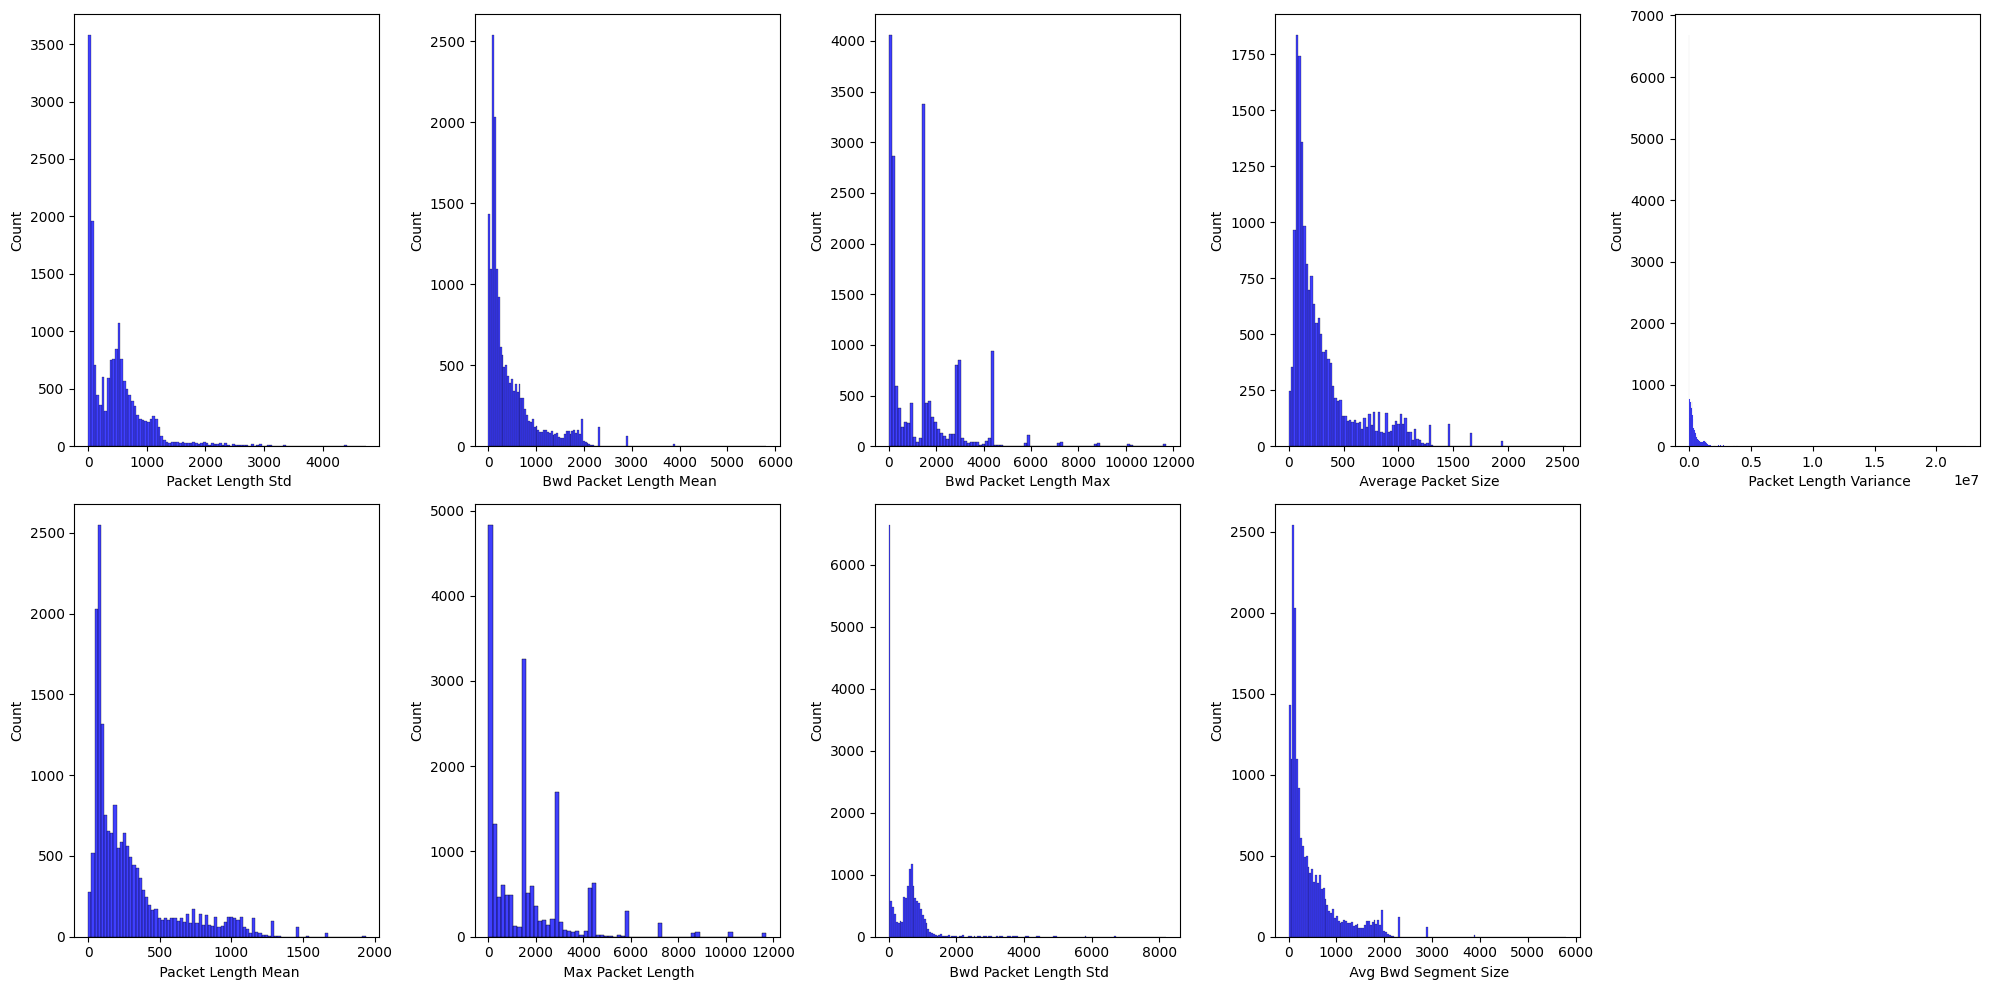

In [133]:
plt.suptitle("Univariant Analysis For Numeric Features", fontsize=20, fontweight='bold', alpha=0.8, y=1.)
plt.figure(figsize=(20,10))
numeric_features=ddos_data.select_dtypes(include=['int64', 'float64']).columns
for i in range(0, len(numeric_features)):
    ax=plt.subplot(2, 5, i + 1)
    sns.histplot(ddos_data[numeric_features[i]], color="blue", ax=ax)
    plt.xlabel(numeric_features[i])
    plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

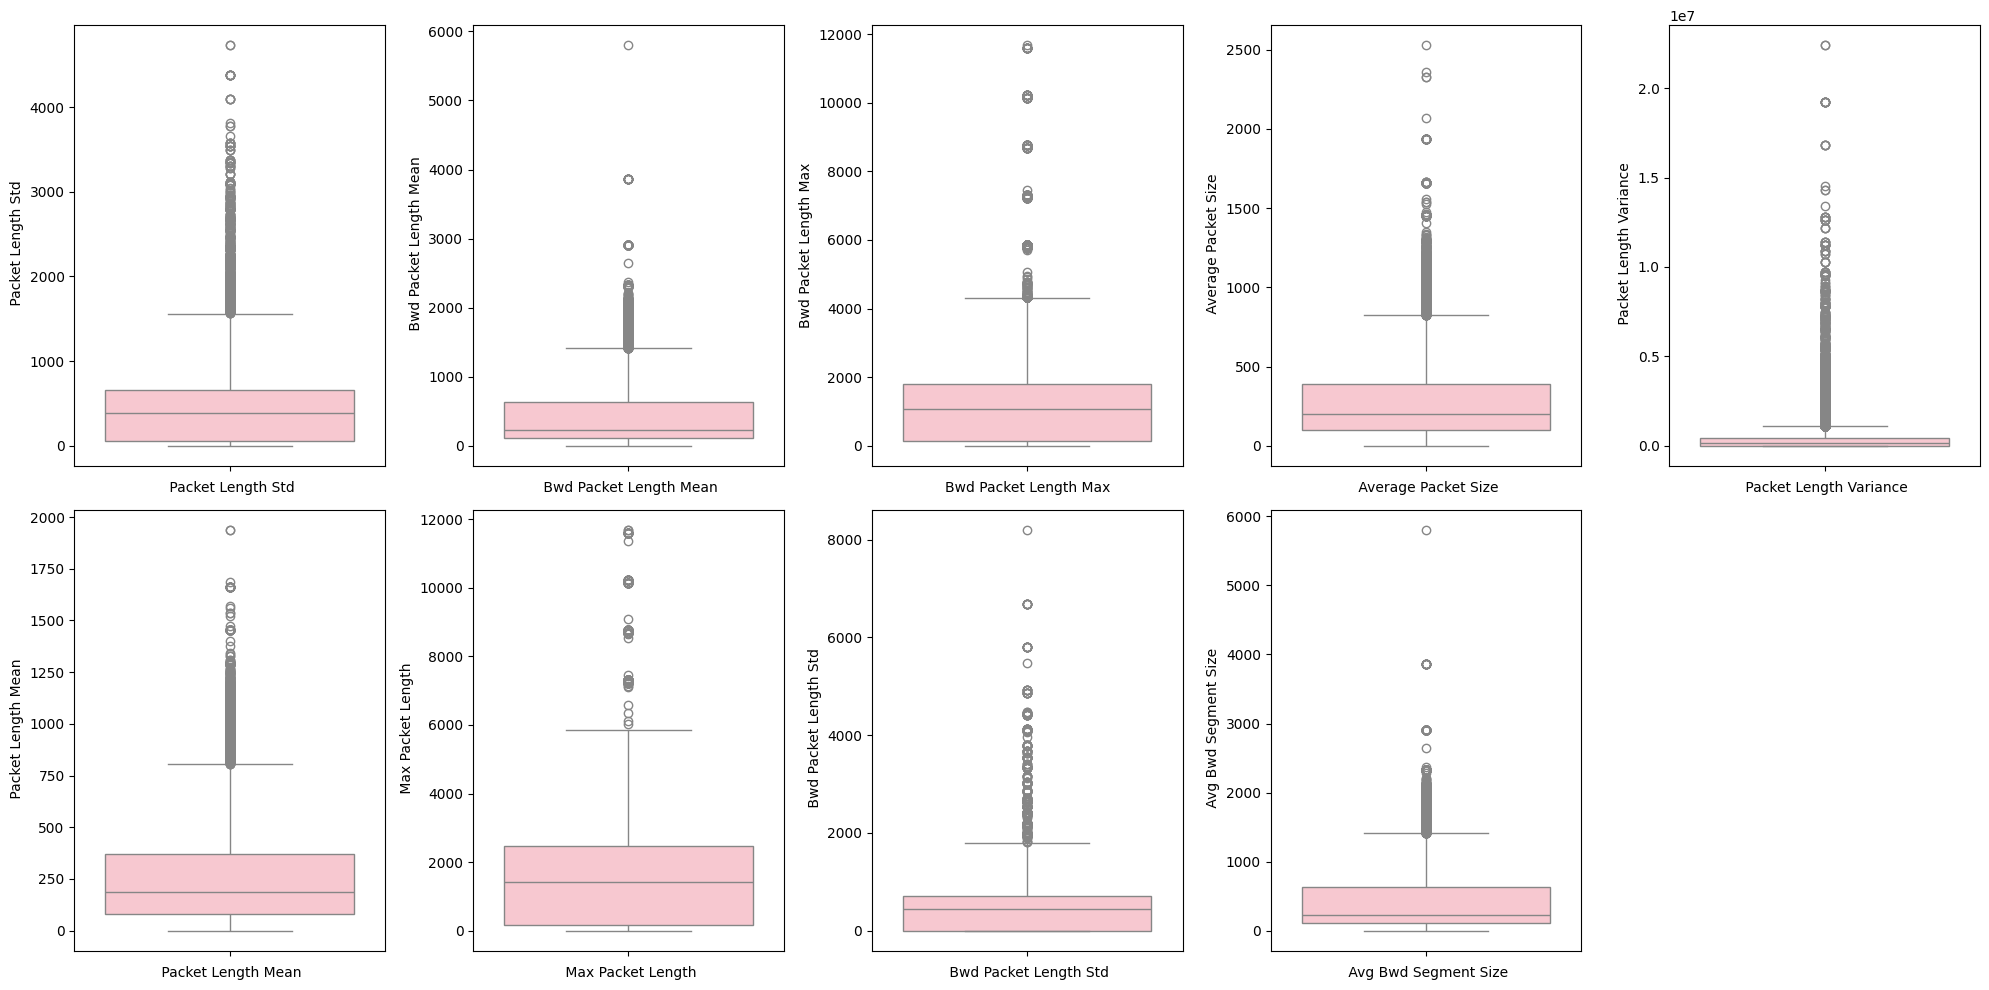

In [134]:
plt.suptitle("Univariant Analysis For Numeric Features in Boxplot", fontsize=20, fontweight='bold', alpha=0.8, y=1.)
plt.figure(figsize=(20,10))
numeric_features=ddos_data.select_dtypes(include=['int64', 'float64']).columns
for i in range(0, len(numeric_features)):
    ax=plt.subplot(2, 5, i + 1)
    sns.boxplot(ddos_data[numeric_features[i]], color="pink", ax=ax)
    plt.xlabel(numeric_features[i])
    plt.tight_layout()
plt.show()

In [135]:
ddos_data[numeric_features].skew()

Packet Length Std         2.268134
 Bwd Packet Length Mean    1.925791
Bwd Packet Length Max      1.872132
 Average Packet Size       1.817124
 Packet Length Variance    7.119655
 Packet Length Mean        1.656195
 Max Packet Length         1.898965
 Bwd Packet Length Std     3.334077
 Avg Bwd Segment Size      1.925791
dtype: float64

In [136]:
def remove_outliers_IQR(col, df):


    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    iqr = Q3 - Q1

    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr

    df.loc[(df[col]>upper_limit),col] = upper_limit
    df.loc[(df[col]<lower_limit),col] = lower_limit

    return df

In [137]:
for col in numeric_features:
    ddos_data=remove_outliers_IQR(col, ddos_data)

<Figure size 640x480 with 0 Axes>

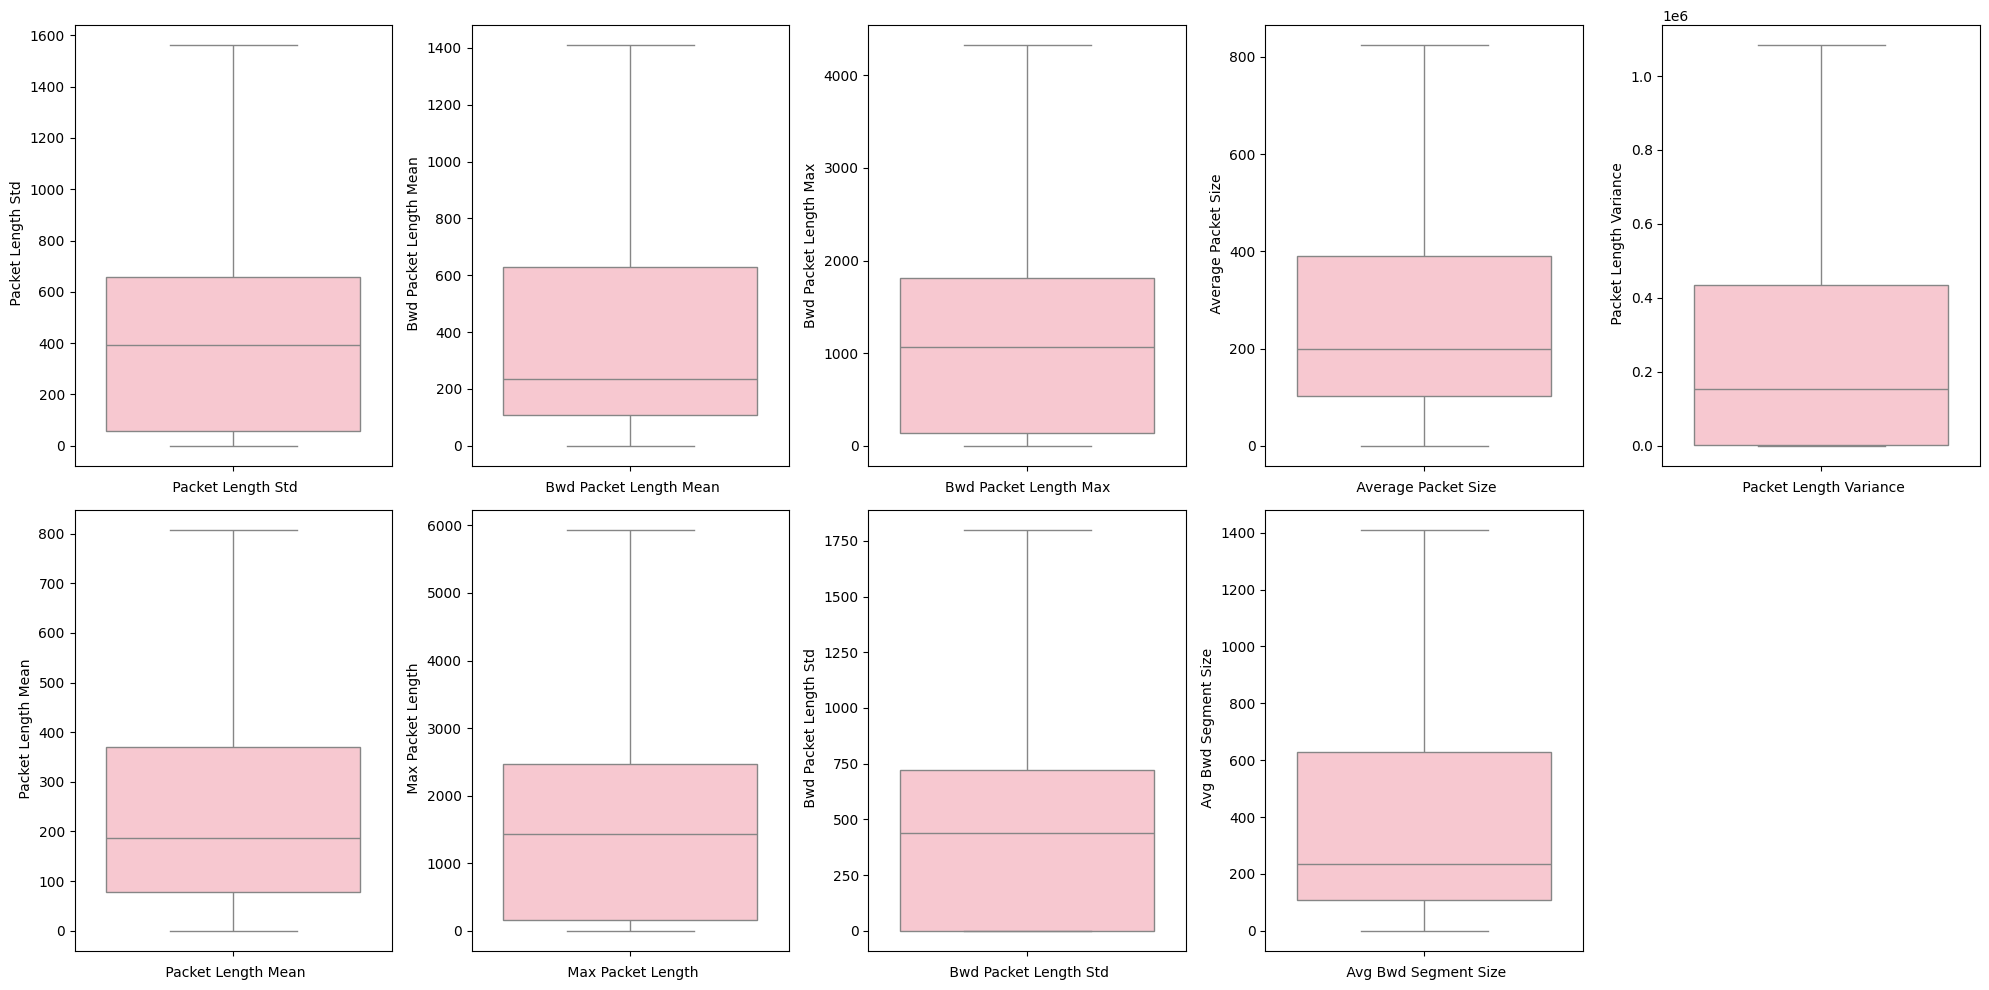

In [138]:
plt.suptitle("Univariant Analysis For Numeric Features in Boxplot", fontsize=20, fontweight='bold', alpha=0.8, y=1.)
plt.figure(figsize=(20,10))
numeric_features=ddos_data.select_dtypes(include=['int64', 'float64']).columns
for i in range(0, len(numeric_features)):
    ax=plt.subplot(2, 5, i + 1)
    sns.boxplot(ddos_data[numeric_features[i]], color="pink", ax=ax)
    plt.xlabel(numeric_features[i])
    plt.tight_layout()
plt.show()

In [139]:
ddos_data[numeric_features].skew()

Packet Length Std         0.977605
 Bwd Packet Length Mean    1.196499
Bwd Packet Length Max      0.956019
 Average Packet Size       1.103751
 Packet Length Variance    1.190556
 Packet Length Mean        1.115742
 Max Packet Length         1.130074
 Bwd Packet Length Std     0.812352
 Avg Bwd Segment Size      1.196499
dtype: float64

In [140]:
from sklearn.preprocessing import FunctionTransformer

function_transformer=FunctionTransformer(np.cbrt, validate=True)
ddos_data[numeric_features]=function_transformer.fit_transform(ddos_data[numeric_features])

<Figure size 640x480 with 0 Axes>

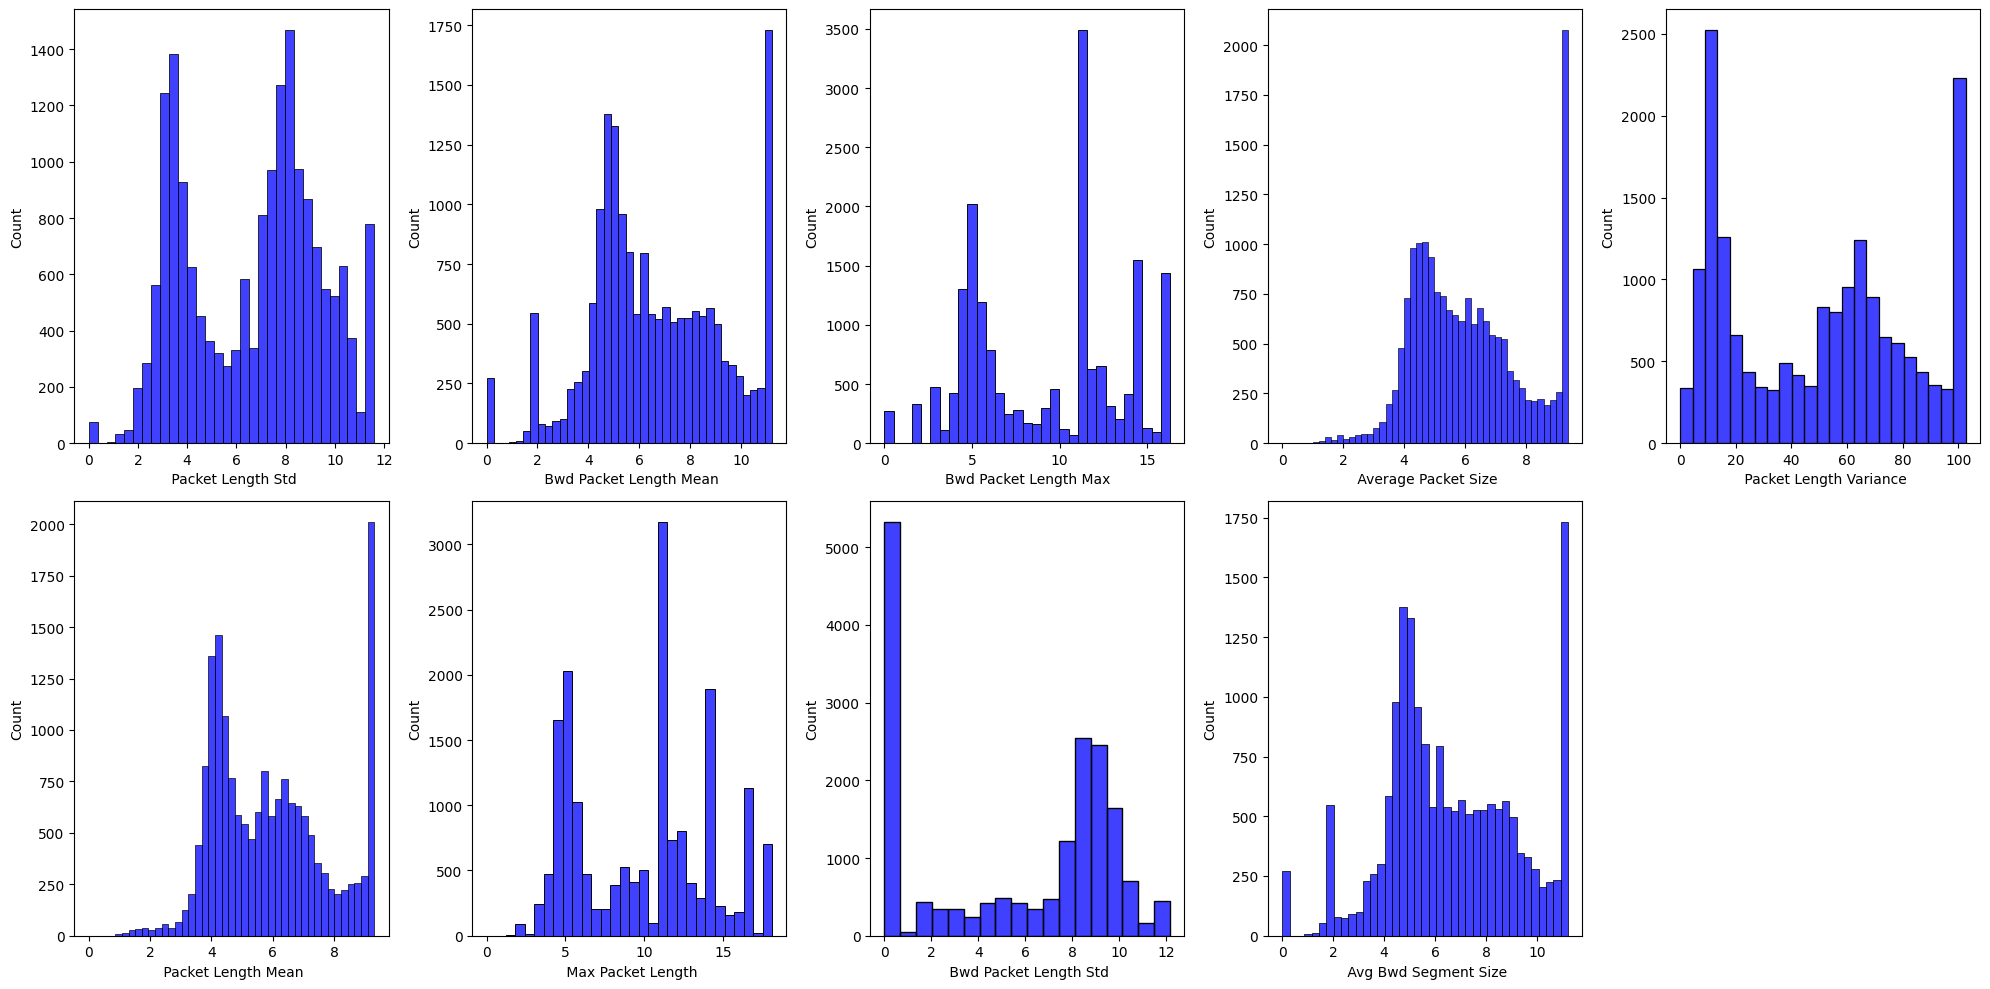

In [141]:
plt.suptitle("Univariant Analysis For Numeric Features", fontsize=20, fontweight='bold', alpha=0.8, y=1.)
plt.figure(figsize=(20,10))
numeric_features=ddos_data.select_dtypes(include=['int64', 'float64']).columns
for i in range(0, len(numeric_features)):
    ax=plt.subplot(2, 5, i + 1)
    sns.histplot(ddos_data[numeric_features[i]], color="blue", ax=ax)
    plt.xlabel(numeric_features[i])
    plt.tight_layout()
plt.show()

In [50]:
ddos_data[numeric_features].skew()

Packet Length Std        -0.167213
 Bwd Packet Length Mean   -0.047196
Bwd Packet Length Max     -0.163818
 Average Packet Size      -0.009413
 Packet Length Variance   -0.235117
 Packet Length Mean       -0.014969
 Max Packet Length        -0.132950
 Bwd Packet Length Std    -0.367704
 Avg Bwd Segment Size     -0.047196
dtype: float64

In [142]:
ddos_data[numeric_features].skew()

Packet Length Std        -0.112270
 Bwd Packet Length Mean    0.081433
Bwd Packet Length Max     -0.030972
 Average Packet Size       0.359432
 Packet Length Variance    0.123076
 Packet Length Mean        0.381349
 Max Packet Length         0.051747
 Bwd Packet Length Std    -0.306766
 Avg Bwd Segment Size      0.081433
dtype: float64

<Axes: xlabel=' Label', ylabel='count'>

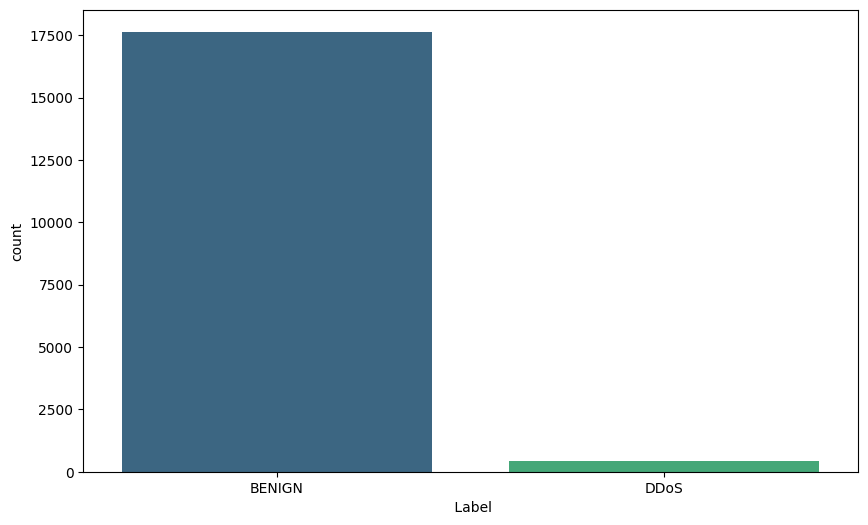

In [34]:
ddos_data[' Label'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(x=' Label', data=ddos_data, palette='viridis')

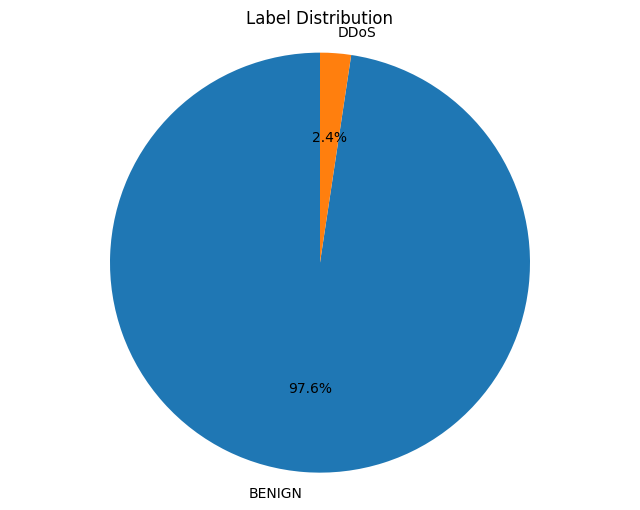

In [35]:
count=ddos_data[' Label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(count, labels=count.index, autopct='%1.1f%%', startangle=90)
plt.title('Label Distribution')
plt.axis('equal')
plt.show()

<Axes: >

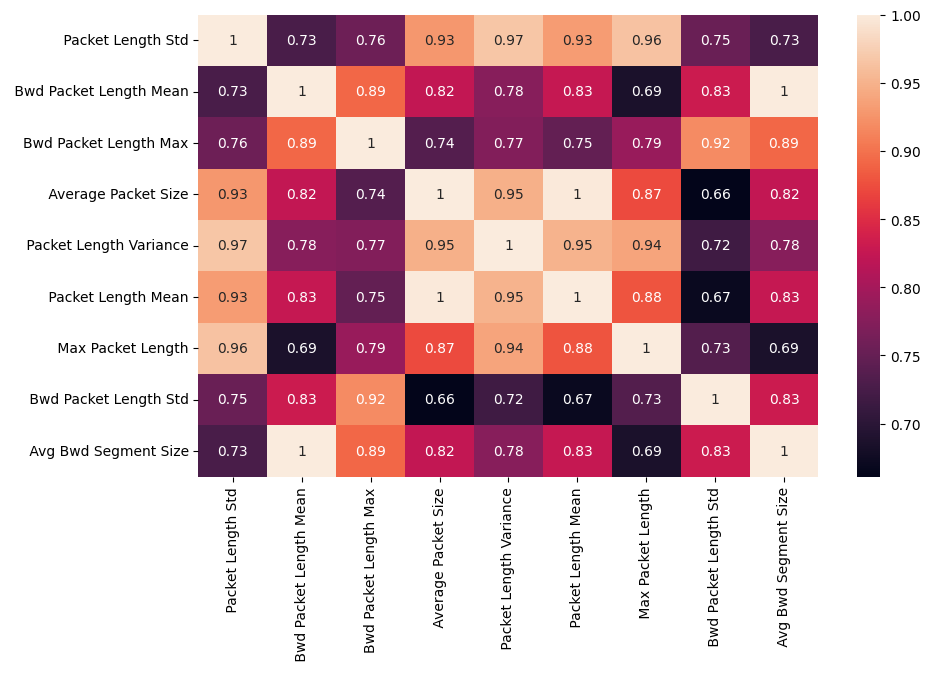

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(ddos_data[numeric_features].corr(), annot=True)

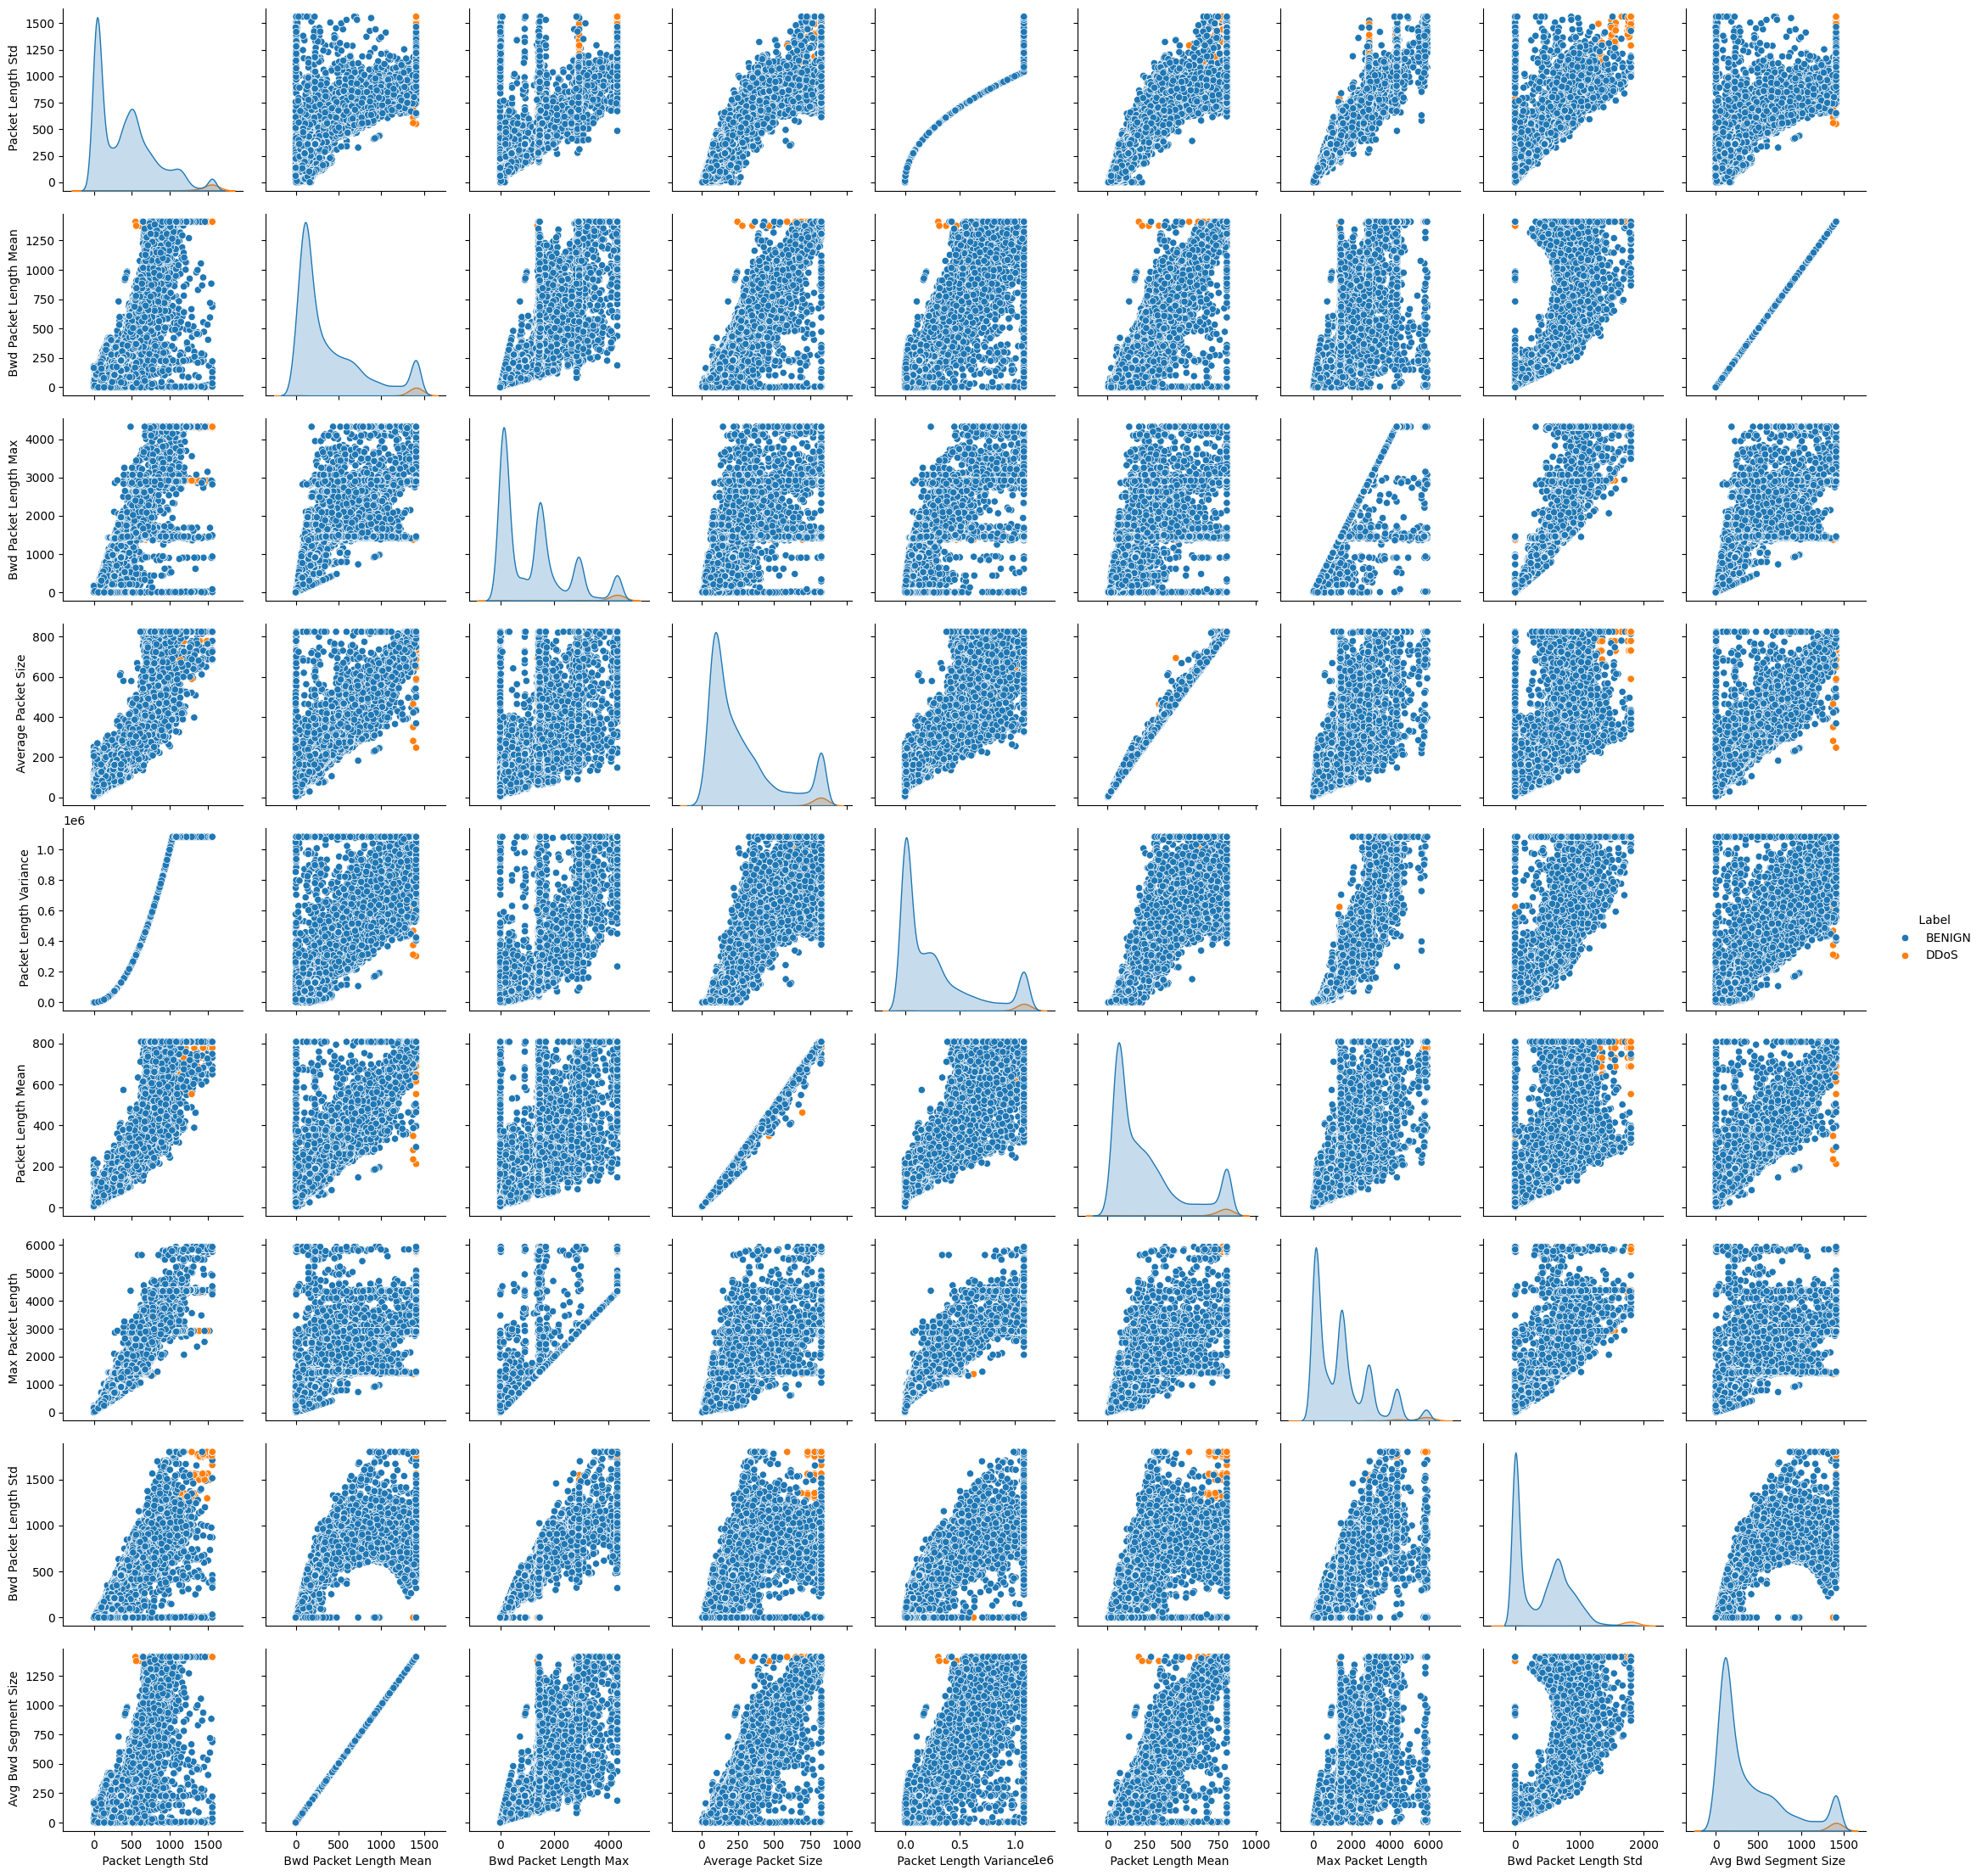

In [42]:
sns.pairplot(ddos_data, hue=' Label')